# Analysis of empirical AEA data set from Peter *et al.* 2016 

See https://github.com/NovembreLab/eems-around-the-world/blob/master/ for more information (data set from Fig 1). It has about ~4,700 individuals, the goal is to see if the Madagascar population can be connected with a long range edge (i.e., does it show high residual with default `feems` fit?)

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

# feems
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

### Data wrangling to get `.coord` file

The coordinates are in the `.pop_geo` file and the population order is in the `.pop_order` file. The individual meta-data is in the `.indiv_meta` file (sampleID, popID, which study, etc.) -- need to put these things together into 1 file. 

In [3]:
data_path = pkg_resources.resource_filename("feems", "data/AEA")

location_data = pd.read_csv("{}/c1global1nfd.pop_geo".format(data_path))
sample_data = pd.read_csv("{}/c1global1nfd.indiv_meta".format(data_path))
order = pd.read_table("{}/c1global1nfd.order".format(data_path), header=None, sep=" ")

meta_data = sample_data.merge(location_data)

# aseed = int(date.today().strftime("%Y%m%d"))
# np.random.seed(aseed)

# sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
# long_jitter = np.random.normal(meta_data['longitude'], sd)
# lat_jitter = np.random.normal(meta_data['latitude'], sd)
# long_jitter = ["%2.2f" % i for i in long_jitter]
# lat_jitter = ["%2.2f" % i for i in lat_jitter]
# temp_data = pd.DataFrame({'longitude':long_jitter,
#                             'latitude': lat_jitter})
# temp_data.to_csv("~/feems/feems/data/AEA/c1global1nfd-%d.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
#                     columns=('longitude', 'latitude'))

## Reading in the data

In [4]:
(bim, fam, G) = read_plink("{}/c1global1nfd".format(data_path))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


In [5]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

n_samples=4697, n_snps=19954


In [6]:
%%time
# setup graph
coord = np.loadtxt("{}/c1global1nfd-{}.coord".format(data_path,'20210708'))  # sample coordinates
outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswat/feems/feems/data/grid_250.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 21.7 s, sys: 78.2 ms, total: 21.8 s
Wall time: 22 s


In [ ]:
#outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
np.max(outer[:,1])

In [7]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges)

CPU times: user 11min 50s, sys: 32 s, total: 12min 22s
Wall time: 12min 37s


In [8]:
projection = ccrs.PlateCarree(central_longitude=80.0)

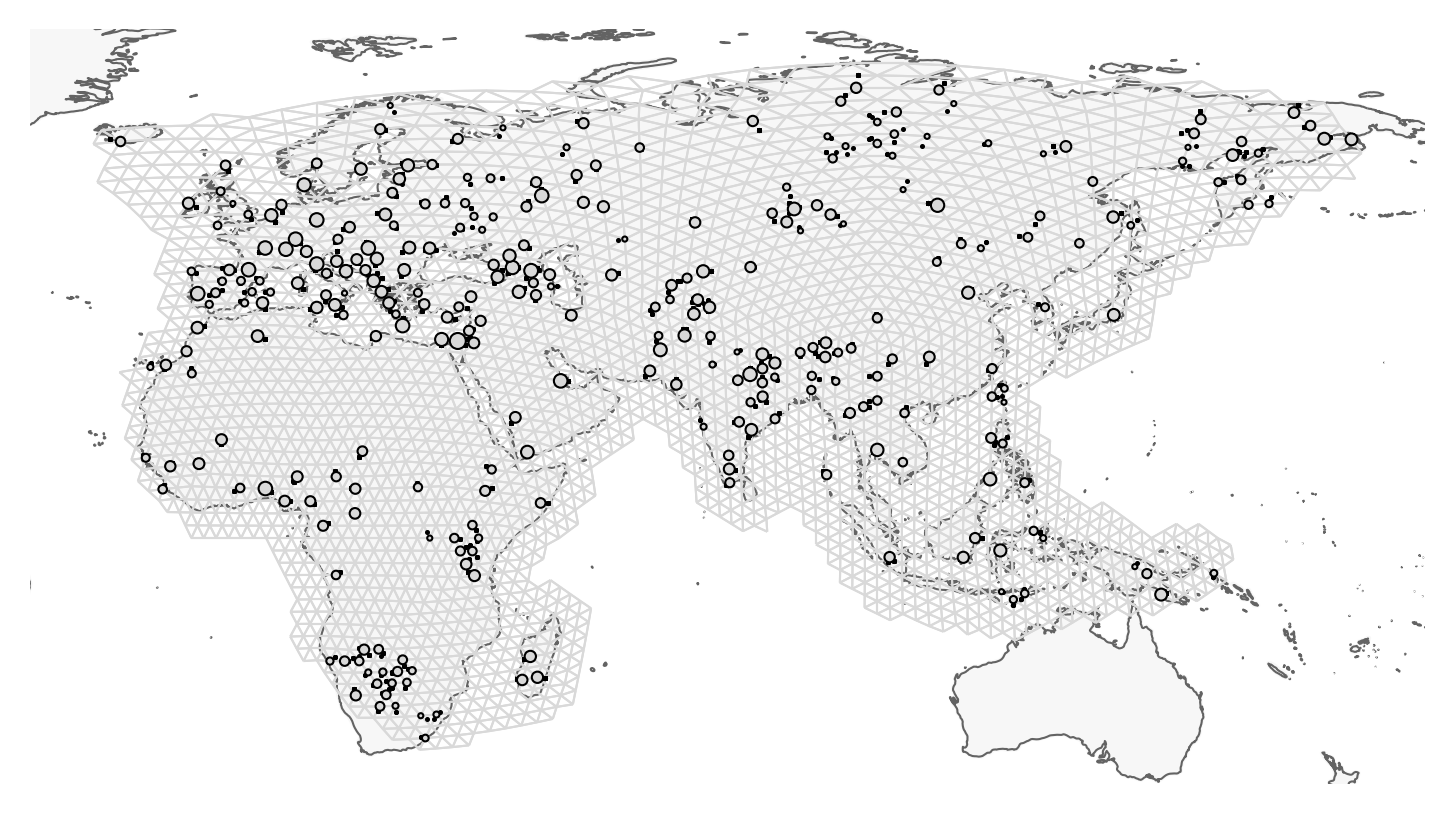

In [13]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [9]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=14/20 alpha=1/1

KeyboardInterrupt: 

In [ ]:
%%time
#comp_genetic_vs_fitted_distance(sp_graph, lamb=lamb_cv, plotFig=True)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=10, lamb=lamb_cv, plotFig=False)

constant-w/variance fit, converged in 138 iterations, train_loss=-1419354.4568557
lambda=5.5000000, alpha=0.3115610, converged in 157 iterations, train_loss=-2073644.5589377


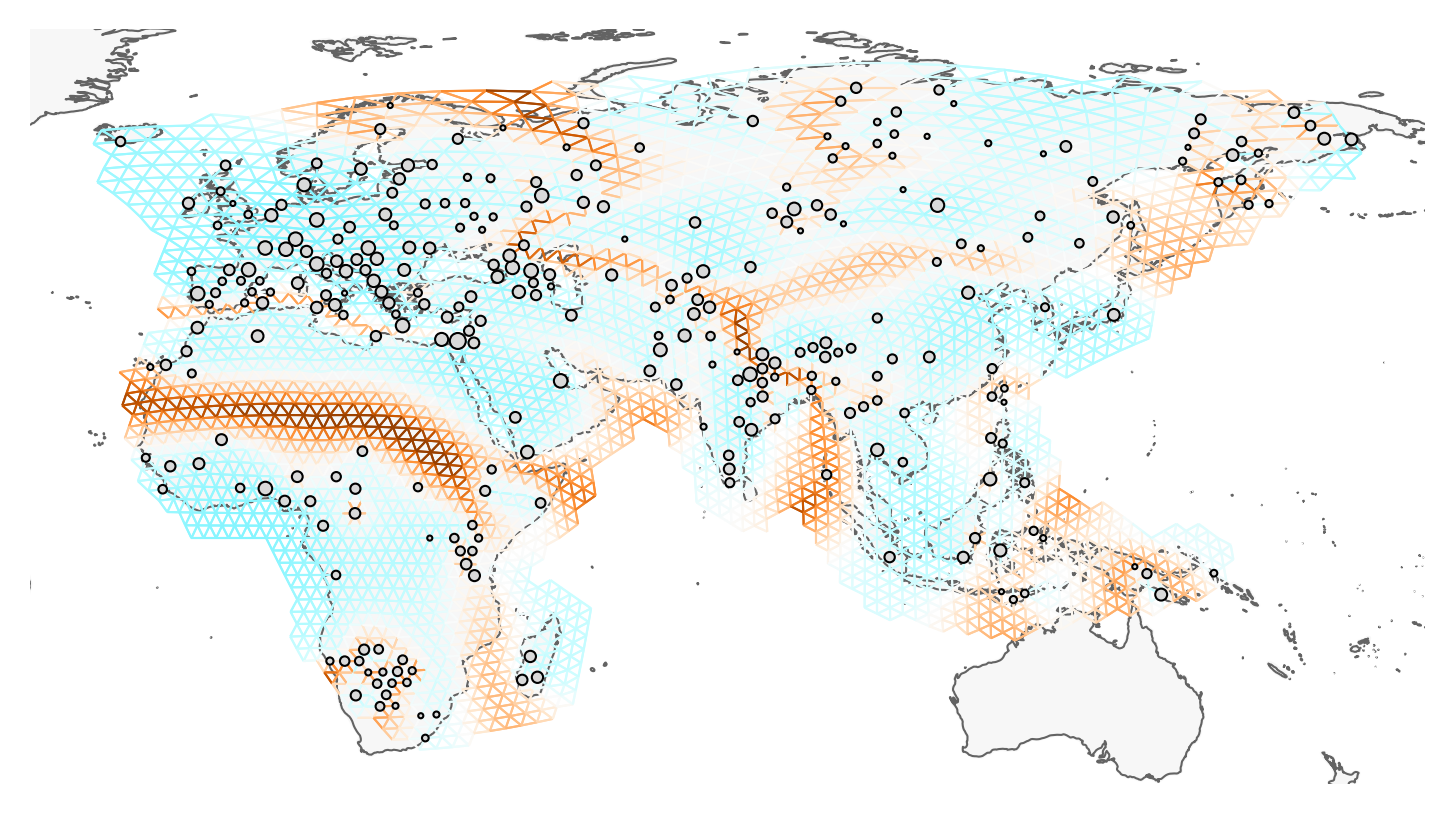

In [9]:
sp_graph.fit(lamb=5.5)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
#plt.savefig('~/feems/AEA-lambdacv.png')

In [ ]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

In [ ]:
## code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes),1].values.reshape(len(max_res_nodes),2)

In [ ]:
[sample_data['sampleId'][sample_data['popId']==int(popid)] for popid in node_to_pop.iloc[np.ravel(max_res_nodes),1]]
[location_data[['latitude','longitude']][location_data['popId']==int(popid)] for popid in node_to_pop.iloc[np.ravel(max_res_nodes),1]]

In [ ]:
print(max_res_nodes)
node_to_pop['nodes'][np.ravel(max_res_nodes)[0:10]]

### Adding the above edges to the graph 

Here, I will add the 6 edges (3 Madagascar - 2 Papuan) to the previous graph and check for new top residuals from this fit (after accounting for the long range ones, what is left over?)

In [10]:
lrn = list(it.product((2323,2312,2310),(2738,2696)))
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for x in lrn:
    edges_lr.append(list(tuple(y+1 for y in x)))
sp_graph_lr = SpatialGraph(genotypes, coord, grid, np.array(edges_lr))

# cv_err_lr = run_cv(sp_graph_lr, lamb_grid, n_folds=10, factr=1e10)

# # average over folds
# mean_cv_err_lr = np.mean(cv_err_lr, axis=0)

# # argmin of cv error
# lamb_cv_lr = float(lamb_grid[np.argmin(mean_cv_err_lr)])

In [ ]:
%%time
max_res_nodes_lr = comp_genetic_vs_fitted_distance(sp_graph_lr, n_lre=10, lamb=lamb_cv_lr, plotFig=False)

In [11]:
sp_graph_lr.fit(lamb=5.5)

constant-w/variance fit, converged in 135 iterations, train_loss=-1321993.4952896
lambda=5.5000000, alpha=0.3333568, converged in 265 iterations, train_loss=-2066570.2606570


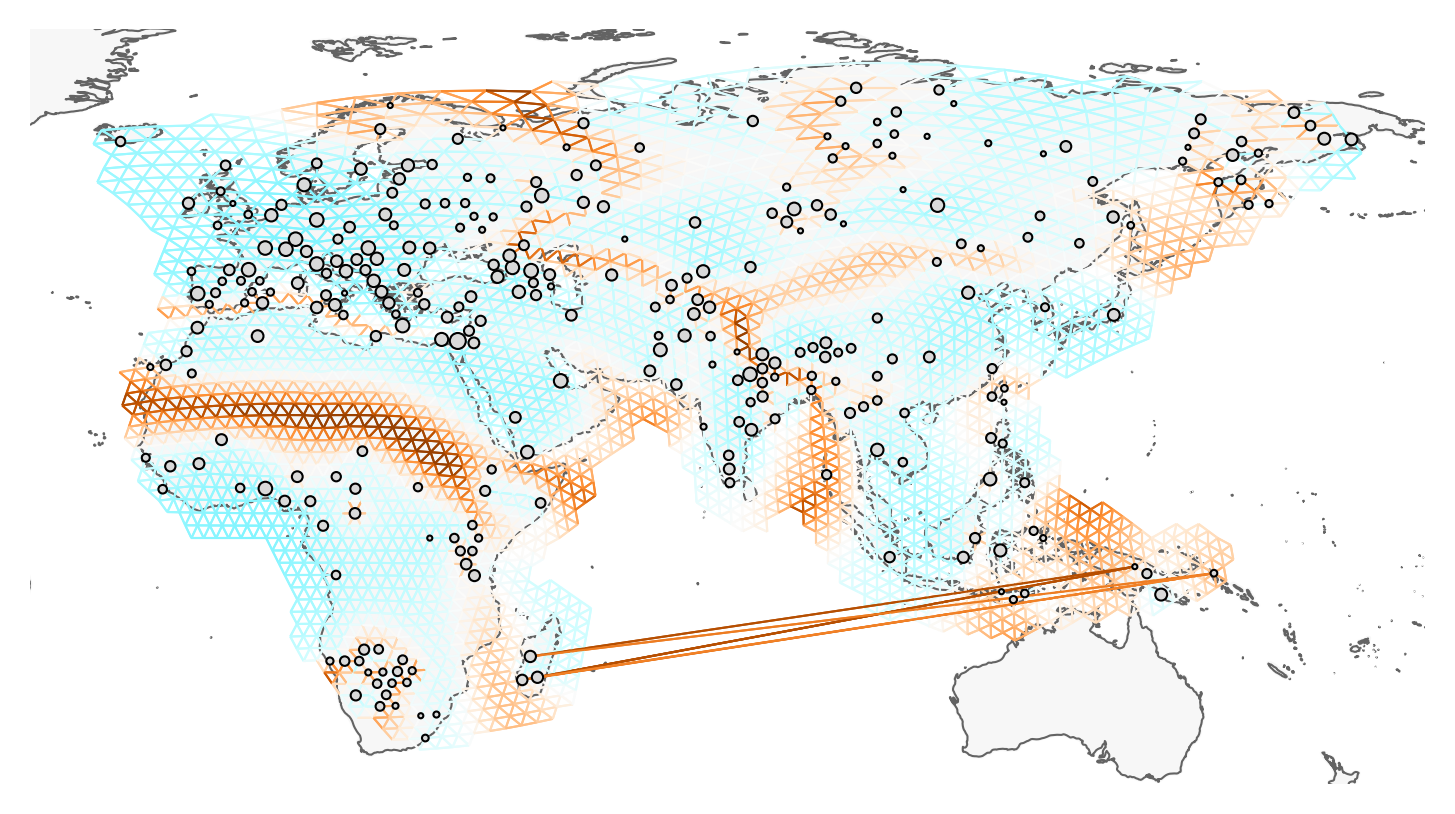

In [12]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes_lr),1].values.reshape(10,2)

In [ ]:
comp_genetic_vs_fitted_distance(sp_graph, lamb=10.0, plotFig=True)

In [ ]:
comp_genetic_vs_fitted_distance(sp_graph_lr, lamb=lamb_cv_lr, plotFig=True)

In [22]:
obj = Objective(sp_graph)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()
obj_lr = Objective(sp_graph_lr)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() > obj.neg_log_lik():
    print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(2.*(obj.neg_log_lik() - obj_lr.neg_log_lik()),chi2.sf(2.*(obj.neg_log_lik() - obj_lr.neg_log_lik()),6)))

Model with long-range edges fits better than default by -234070.14 log units with p-value of 1.00e+00


In [19]:
print(obj_lr.neg_log_lik())
obj.neg_log_lik()

-2106804.0581610464


-2223839.1287903883

In [ ]:
print(np.where(query_node_attributes(sp_graph,"n_samples")!=0))

In [ ]:
#[i for i in permuted_idx if 1710 in query_node_attributes(sp_graph,"sample_idx")[i]]
sample_data['sampleId']
query_node_attributes(sp_graph,"sample_idx")[10]

In [ ]:
max_res_nodes

In [ ]:
[np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids[0:3]]

In [ ]:
obs_perm_ids

## Subsetting other regions: Mediterranean + North African and Indian subcontinent 

Below, I will subset the data from these two regions to see if `feems` identifies local features that are not apparent in the global data set. This is actually available as a WEA data set from the paper. If only the Mediterranean is needed, I can subset based on a latitudinal cut-off ($>42^o$ N & $>40^o$ E)

In [ ]:
data_path = pkg_resources.resource_filename("feems", "data/WEA")

location_data = pd.read_csv("{}/c1eumedi1nf.pop_geo".format(data_path))
sample_data = pd.read_csv("{}/c1eumedi1nf.indiv_meta".format(data_path))
order = pd.read_table("{}/c1eumedi1nf.order".format(data_path), header=None, sep=" ")

meta_data = sample_data.merge(location_data)

# aseed = int(date.today().strftime("%Y%m%d"))
# np.random.seed(0)

sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
long_jitter = np.random.normal(meta_data['longitude'], sd)
lat_jitter = np.random.normal(meta_data['latitude'], sd)
long_jitter = ["%2.2f" % i for i in long_jitter]
lat_jitter = ["%2.2f" % i for i in lat_jitter]
temp_data = pd.DataFrame({'longitude':long_jitter,
                            'latitude': lat_jitter})
temp_data.to_csv("~/feems/feems/data/WEA/c1eumedi1nf-%d.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
                    columns=('longitude', 'latitude'))

In [ ]:
(bim, fam, G) = read_plink("{}/c1eumedi1nf".format(data_path))

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

In [ ]:
%%time
# setup graph
coord = np.loadtxt("{}/c1eumedi1nf-{}.coord".format(data_path,int(date.today().strftime("%Y%m%d"))))  # sample coordinates
outer = np.loadtxt("{}/c1eumedi1nf.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswat/feems/feems/data/grid_100.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

In [ ]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges)

In [ ]:
projection = ccrs.PlateCarree(central_longitude=35.0)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [ ]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

In [ ]:
sp_graph.fit(lamb = lamb_cv)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
fig.savefig("/Users/vivaswat/feems/WEA_lambcv.png", dpi=300)

In [ ]:
%%time
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=6, lamb=lamb_cv, plotFig=False)

In [ ]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

# code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [ ]:
sample_data

In [ ]:
node_to_pop

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes),0].values.reshape(len(max_res_nodes),2)
# 1. southern italy - latvia
# 2. montenegro - finland (appears a lot)
# 3. south western russia - finland
# 4. northcentral algeria - ukraine
# 5. libya - lithuania
# 4. turkey - finland

In [ ]:
[location_data[['latitude','longitude']][location_data['popId']==int(popid)] for popid in node_to_pop.iloc[np.ravel(max_res_nodes),1]]

In [ ]:
lrn = [tuple(val) for val in node_to_pop.iloc[np.ravel(max_res_nodes),0].values.reshape(len(max_res_nodes),2)]
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for x in lrn:
    edges_lr.append(list(tuple(y+1 for y in x)))
sp_graph_lr = SpatialGraph(genotypes, coord, grid, np.array(edges_lr))

cv_err_lr = run_cv(sp_graph_lr, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err_lr = np.mean(cv_err_lr, axis=0)

# argmin of cv error
lamb_cv_lr = float(lamb_grid[np.argmin(mean_cv_err_lr)])

In [ ]:
sp_graph_lr.fit(lamb = lamb_cv_lr)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
fig.savefig("/Users/vivaswat/feems/WEA_lambCVlr.png", dpi=300)

In [ ]:
#comp_genetic_vs_fitted_distance(sp_graph, lamb=lamb_cv, plotFig=True)

In [ ]:
#comp_genetic_vs_fitted_distance(sp_graph_lr, lamb=lamb_cv_lr, plotFig=True)

In [ ]:
obj = Objective(sp_graph)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()

In [ ]:
obj_lr = Objective(sp_graph_lr)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better by %.2f units"%(-2*(obj_lr.neg_log_lik() - obj.neg_log_lik())))

In [ ]:
# need to convert to a list of tuples...
#plot_default_vs_long_range(sp_graph, sp_graph_lr, max_res_nodes=[(693,1062),(699,1427),(1227,1427),(559,1085),(796,997),(816,1427)], lamb=lamb_cv)

### Running the above analysis with a trimmed data set

Here, I will remove populations with sample sizes fewer than or equal to 5. This should remove some of the long range edges we've been seeing. 

In [ ]:
# creating a lsit of tuples of pop with sample sizes
cnt = sample_data.popId.value_counts()
popsamp = [tuple((x, y)) for x, y in cnt.items()]

In [ ]:
bigpops = [ps[0] for ps in popsamp if ps[1]>5]

In [ ]:
# code to exclude pops with small sizes i.e., not in bigpops variable 
location_data_bg = location_data.loc[location_data['popId'].isin(bigpops)]

sample_data_bg = sample_data.loc[sample_data['popId'].isin(bigpops)]
order_bg = order.loc[order[0].isin(sample_data_bg['sampleId'])]

meta_data = sample_data_bg.merge(location_data_bg)

sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
long_jitter = np.random.normal(meta_data['longitude'], sd)
lat_jitter = np.random.normal(meta_data['latitude'], sd)
long_jitter = ["%2.2f" % i for i in long_jitter]
lat_jitter = ["%2.2f" % i for i in lat_jitter]
temp_data = pd.DataFrame({'longitude':long_jitter,
                            'latitude': lat_jitter})
temp_data.to_csv("~/feems/feems/data/WEA/c1eumedi1nf-%d-bg.coord"%int(date.today().strftime("%Y%m%d")), sep=" ", header=False, index=False,
                    columns=('longitude', 'latitude'))

In [ ]:
fam_bg = fam.loc[fam['fid'].isin(sample_data_bg['sampleId'])]
ta['sampleId'].isin(sample_data_bg['sampleId'])]

In [ ]:
G_bg = G[:,sample_data['sampleId'].isin(sample_data_bg['sampleId'])]

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G_bg)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

In [ ]:
# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=np.array(temp_data, dtype='float'), 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

In [ ]:
np.shape(genotypes)

In [ ]:
%%time
sp_graph = SpatialGraph(genotypes, np.array(temp_data, dtype='float'), grid, edges)

In [ ]:
# projection = ccrs.PlateCarree(central_longitude=35.0)
# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
#         obs_node_size=1.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map()
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

In [ ]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

In [ ]:
# sp_graph.fit(lamb = lamb_cv)

# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=1.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# fig.savefig("/Users/vivaswat/feems/WEA_bg_lambcv.png", dpi=300)

In [ ]:
%%time
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=6, lamb=lamb_cv, plotFig=False)

In [ ]:
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]

# code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(sp_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [np.unique(sample_data['popId'][query_node_attributes(sp_graph,"sample_idx")[x]]) for x in obs_perm_ids]

In [ ]:
node_to_pop.iloc[np.ravel(max_res_nodes),1].values.reshape(len(max_res_nodes),2)

In [ ]:
# comp_genetic_vs_fitted_distance(sp_graph, lamb=lamb_cv, plotFig=True)

### Example workflow

#### Empirical data sets

1. Read in meta data files (`.pop_geo`, `.indiv_meta`, `.order`) and `.coord`, if available or create it 

2. Read in genotype files (`.bim`., `.fam`, `.bed`) and impute missing genotypes with mean 

3. Set up the graph objects by reading in `.coord`, `.outer` and `.shp`

4. Fit the SpatialGraph object using the CV procedure (been using 10-fold, but better to use leave-one-out)

5. Obtain `max_res_nodes` using the `comp_genetic_vs_fitted_distance` function

6. Through manual inspection (or using code), add top 3/5 edges and create `sp_graph_lr`

7. Comparison:  
    a. Run `comp_genetic_vs_fitted_distance(..., plotFig=True)` on both objects  
    b. Obtain fits on global grid using code chunks  
    c. Get *nll* from `Objective`  

#### Simulated data sets 

*Can use leave-one-out CV for all cases, interestingly $\lambda$ is always between 6 and 14*

1. Create a *default, skeleton* graph with no long range edges -- no SpaitalGraph object here

2. Create a `lrn` list of nodes to be connected with long range edges

3. Create a SpatialGraph object that contains these edges: call it `sp_Graph_def`

4. Searching space:  
    a. Exact - Create a `pd.df` with all possible edges and populate using `add_edge_get_nll`   
    b. Heuristic - Create a `pd.df` with nearest neighbors or convex hull nodes around `max_res_nodes(..., n_lre=1)` 

5. Check if the two searches return the same pair of nodes as each other and as simulated

6. Create a `sp_Graph_lr` with the returned pair of nodes 

7. Comparison:  
    a. Run `comp_genetic_vs_fitted_distance(..., plotFig=True)` on both objects  
    b. Get fit of the extra edge on default graph with the default graph
    c. Get *nll* from `Objective`   

### Sandbox for developing the code to plot residual matrix

In [ ]:
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
sp_graph.fit(lamb=lamb_cv)
obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()

In [ ]:
# use genetic covariance in producing a dendrogram on y-axis...(need to reorder before filling up the matrix)
resnode = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
resnode[np.tril_indices_from(resmat, k=-1)] = np.abs(res.resid)
mask = np.zeros_like(resnode)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(dpi=200)
    # try clustermap(col_cluster=False)
    ax = sns.heatmap(resnode, mask=mask, square=True,  cmap=sns.color_palette("crest", as_cmap=True), xticklabels=node_to_pop['pops'])
    plt.show()